In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join

In [2]:
def load_eval(path):
    types = {'robot_state': str}
    df = pd.read_json(path, dtype=types)
    lowest_time = df['time_secs'][0] + 1e-9 * df['time_nsecs'][0]
    relative_times = df['time_secs'] + 1e-9 * df['time_nsecs'] - lowest_time
    df['relative_time'] = relative_times
    return df

In [3]:
fileRe = re.compile(r"\w+\.\w+_\w+\.\w+_hc\.(\d+)_(\d+)\.json")
startIter = 0
endIter = 24
def CollectData(dirPath, label):
    start = True
    output = None
    times = {'Human Count': [], 'Final Time': [], 'Policy': []}
    onlyFiles = [f for f in listdir(dirPath) if isfile(join(dirPath, f))]
    for file in onlyFiles:
        match = fileRe.match(file)
        humans = int(match.group(1))
        iteration = int(match.group(2))
        #humans = int(file.split('.')[-2])
        if (iteration >= startIter and iteration <= endIter):
            df = load_eval(dirPath + file)
            hColumn = [humans] * len(df.index)
            labelColumn = [label] * len(df.index)
            finalTime = df['relative_time'].iloc[-1]
            iterColumn = [iteration] * len(df.index)
            timeColumn = [finalTime] * len(df.index)
            times['Human Count'].append(humans)
            times['Final Time'].append(finalTime)
            times['Policy'].append(label)
            df['Human Count'] = hColumn
            df['Policy'] = labelColumn
            df['Total Time'] = timeColumn
            df['Trial'] = iterColumn
            if (start):
                output = df
            else:
                output = pd.concat([output, df], axis=0)
            start = False
    print(len(output))
    return output, pd.DataFrame.from_dict(times)

def CountSuccess(dataDict, timeout):
    output = None
    for key, value in dataDict.items():
        score = 0
        for entry in value:
            time = entry['relative_time'].iloc[-1]
            if (time < timeout):
                score += 1
        output[key] = score
    return output

def CalculateSpeed(df):
    vels_times = df[['robot_vel_x', 'robot_vel_y', 'relative_time']].fillna(0)
    robot_vel_x = vels_times['robot_vel_x']
    robot_vel_y = vels_times['robot_vel_y']
    robot_speed = (robot_vel_x**2 + robot_vel_y**2)**0.5
    return robot_speed

def CalculateForce(df):
    robot_state = df['robot_state']
    df = df[['human_positions', 'robot_pos_x', 'robot_pos_y', 'relative_time']].fillna(0)
    df['robot_state'] = robot_state.fillna('None')
    force_magnitudes = list()
    for index, row in df.iterrows():
        robot_pos_x = row['robot_pos_x']
        robot_pos_y = row['robot_pos_y']
        robot_pos = np.array([robot_pos_x, robot_pos_y])
        human_positions = row['human_positions']
        state = row['robot_state']
        if (human_positions != 0):
            human_positions = np.array([np.array([p[0], p[1]]) for p in human_positions])
            distances = np.linalg.norm(robot_pos - human_positions, axis=1)
            closest_distance = np.min(distances)
            if (state == 'Follow'):
                distances = distances[distances != closest_distance]
                closest_distance = np.min(distances)
            force_magnitude = np.exp(-closest_distance**2 / 5)
            force_magnitudes.append(force_magnitude)
        else:
            force_magnitudes.append(0.0)
    force_magnitudes = pd.Series(force_magnitudes)
    return force_magnitudes

def sigmoid(x):
    return 1 - math.erf(x) #1 / (1 + np.exp(-x))

def closest_point_on_line_segment_to_point(end1, end2, point):
    l2 = np.linalg.norm(end1 - end2)**2
    if np.abs(l2) < 1e-6:
        return end1
    t = max(0, min(1, np.dot(point - end1, end2 - end1) / l2))
    projection = end1 + t * (end2 - end1)
    return projection

def CalculateBlame(df):
    df = df[['robot_pos_x', 'robot_pos_y', 'robot_vel_x', 'robot_vel_y', 'human_positions', 'relative_time']].fillna(0)
    blames = list()
    for index, row in df.iterrows():
        robot_pos_x = row['robot_pos_x']
        robot_pos_y = row['robot_pos_y']
        robot_vel_x = row['robot_vel_x']
        robot_vel_y = row['robot_vel_y']
        human_positions = row['human_positions']
        time = row['relative_time']
        
        if (human_positions != 0):
            robot_pos = np.array([robot_pos_x, robot_pos_y])
            robot_vel = np.array([robot_vel_y, robot_vel_y])
            human_positions = np.array([np.array([p[0], p[1]]) for p in human_positions])

            distances = np.linalg.norm(robot_pos - human_positions, axis=1)
            nearest_human_pos = human_positions[np.argmin(distances)]
        
            endpoint1 = robot_pos
            endpoint2 = robot_pos + robot_vel * 0.5
            p_robot_human_star = closest_point_on_line_segment_to_point(endpoint1, endpoint2, nearest_human_pos)
            blame_human = sigmoid(np.linalg.norm(p_robot_human_star - nearest_human_pos))
            blames.append(blame_human)
        else:
            blames.append(0.0)
        
    blames = pd.Series(blames)
    return blames

def CalculateMetrics(df):
    speeds = CalculateSpeed(df)
    force = CalculateForce(df)
    blame = CalculateBlame(df)
    df["Robot Speed"] = speeds
    df["Force"] = force
    df["Blame"] = blame
    return df

def AverageMetrics(df):
    polList = ['Baseline', 'Reference', 'Nice', 'Greedy']
    output = pd.DataFrame(columns=['Policy','Trial','Force','Blame','Time'])
    for policy in polList:
        for trial in range(2,20,2):
            data = df[df['Policy'] == policy]
            print(data)
            data = data[data['Human Count'] == trial]
            print(data)
            blame = data['Blame'].mean()
            force = data['Force'].mean()
            time = data['Total Time'].mean()
            print(blame)
            print(force)
            print(time)
            entry = [policy, trial, force, blame, time]
            output.loc[len(output)] = entry 
    return output

In [4]:
goAloneDf, goAloneTimes = CollectData(f'/home/jaholtz/code/docker/sldips/results_v6/go_alone/', 'Baseline')
goAloneDf = CalculateMetrics(goAloneDf)
print("Goalone Metrics Calculated")

2061564
Goalone Metrics Calculated


In [5]:
referenceDf, referenceTimes = CollectData(f'/home/jaholtz/code/docker/sldips/results_v6/reference/', 'Reference')
referenceDf = CalculateMetrics(referenceDf)
print("Reference Metrics Calculated")

2904596
Reference Metrics Calculated


In [6]:
niceDf, niceTimes = CollectData(f'/home/jaholtz/code/docker/sldips/results_v6/nice/', 'Nice')
niceDf = CalculateMetrics(niceDf)
print("Nice Metrics Calculated")

2880712
Nice Metrics Calculated


In [7]:
greedyDf, greedyTimes = CollectData(f'/home/jaholtz/code/docker/sldips/results_v6/greedy/', 'Greedy')
greedyDf = CalculateMetrics(greedyDf)
print("Greedy Metrics Calculated")

2383152
Greedy Metrics Calculated


In [8]:
sns.set_style("darkgrid")

fullDf = pd.concat([goAloneDf,referenceDf], axis=0)
fullDf = pd.concat([fullDf,niceDf], axis=0)
fullDf = pd.concat([fullDf,greedyDf], axis=0)
averageDf = AverageMetrics(fullDf)

gaSort = goAloneTimes.sort_values(goAloneTimes.columns[0])
referenceSort = referenceTimes.sort_values(referenceTimes.columns[0])
niceSort = niceTimes.sort_values(niceTimes.columns[0])
greedySort = greedyTimes.sort_values(greedyTimes.columns[0])
fullTime = pd.concat([gaSort,referenceSort], axis=0)
fullTime = pd.concat([fullTime,niceSort], axis=0)
fullTime = pd.concat([fullTime,greedySort], axis=0)

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608735955   465434074          NaN          NaN        2.000   
1     1608735955   487082958    36.651566     3.061064        2.000   
2     1608735955   487373113    36.651566     3.061064        2.000   
3     1608735955   489347934    36.651566     3.061064        2.000   
4     1608735955   512010097    36.651566     3.061064        2.000   
...          ...         ...          ...          ...          ...   
1325  1608750214   496064901    16.007956     6.905680        1.375   
1326  1608750214   516793012    16.007956     6.905680        1.375   
1327  1608750214   539866924    16.007956     6.905680        1.375   
1328  1608750214   541547060    16.007956     6.905680        1.375   
1329  1608750214   541749954    16.007956     6.905680        1.375   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0         nan   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608735955   465434074          NaN          NaN        2.000   
1     1608735955   487082958    36.651566     3.061064        2.000   
2     1608735955   487373113    36.651566     3.061064        2.000   
3     1608735955   489347934    36.651566     3.061064        2.000   
4     1608735955   512010097    36.651566     3.061064        2.000   
...          ...         ...          ...          ...          ...   
1325  1608750214   496064901    16.007956     6.905680        1.375   
1326  1608750214   516793012    16.007956     6.905680        1.375   
1327  1608750214   539866924    16.007956     6.905680        1.375   
1328  1608750214   541547060    16.007956     6.905680        1.375   
1329  1608750214   541749954    16.007956     6.905680        1.375   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0         nan   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608735955   465434074          NaN          NaN        2.000   
1     1608735955   487082958    36.651566     3.061064        2.000   
2     1608735955   487373113    36.651566     3.061064        2.000   
3     1608735955   489347934    36.651566     3.061064        2.000   
4     1608735955   512010097    36.651566     3.061064        2.000   
...          ...         ...          ...          ...          ...   
1325  1608750214   496064901    16.007956     6.905680        1.375   
1326  1608750214   516793012    16.007956     6.905680        1.375   
1327  1608750214   539866924    16.007956     6.905680        1.375   
1328  1608750214   541547060    16.007956     6.905680        1.375   
1329  1608750214   541749954    16.007956     6.905680        1.375   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0         nan   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608735955   465434074          NaN          NaN        2.000   
1     1608735955   487082958    36.651566     3.061064        2.000   
2     1608735955   487373113    36.651566     3.061064        2.000   
3     1608735955   489347934    36.651566     3.061064        2.000   
4     1608735955   512010097    36.651566     3.061064        2.000   
...          ...         ...          ...          ...          ...   
1325  1608750214   496064901    16.007956     6.905680        1.375   
1326  1608750214   516793012    16.007956     6.905680        1.375   
1327  1608750214   539866924    16.007956     6.905680        1.375   
1328  1608750214   541547060    16.007956     6.905680        1.375   
1329  1608750214   541749954    16.007956     6.905680        1.375   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0         nan   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608735955   465434074          NaN          NaN        2.000   
1     1608735955   487082958    36.651566     3.061064        2.000   
2     1608735955   487373113    36.651566     3.061064        2.000   
3     1608735955   489347934    36.651566     3.061064        2.000   
4     1608735955   512010097    36.651566     3.061064        2.000   
...          ...         ...          ...          ...          ...   
1325  1608750214   496064901    16.007956     6.905680        1.375   
1326  1608750214   516793012    16.007956     6.905680        1.375   
1327  1608750214   539866924    16.007956     6.905680        1.375   
1328  1608750214   541547060    16.007956     6.905680        1.375   
1329  1608750214   541749954    16.007956     6.905680        1.375   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0         nan   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608738661   120757102          NaN          NaN        2.000   
1     1608738661   120949029          NaN          NaN        2.000   
2     1608738661   127538919    35.153992     3.147267        2.000   
3     1608738661   147089958    35.153992     3.147267        2.000   
4     1608738661   151830911    35.104073     3.150141        2.000   
...          ...         ...          ...          ...          ...   
3517  1608755693   155388116    15.982105     6.919542        1.375   
3518  1608755693   167484045    15.982105     6.919542        1.375   
3519  1608755693   180013895    15.982105     6.919542        1.375   
3520  1608755693   196181058    15.982105     6.919542        1.375   
3521  1608755693   200259923    15.982105     6.919542        1.375   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0         nan   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608738661   120757102          NaN          NaN        2.000   
1     1608738661   120949029          NaN          NaN        2.000   
2     1608738661   127538919    35.153992     3.147267        2.000   
3     1608738661   147089958    35.153992     3.147267        2.000   
4     1608738661   151830911    35.104073     3.150141        2.000   
...          ...         ...          ...          ...          ...   
3517  1608755693   155388116    15.982105     6.919542        1.375   
3518  1608755693   167484045    15.982105     6.919542        1.375   
3519  1608755693   180013895    15.982105     6.919542        1.375   
3520  1608755693   196181058    15.982105     6.919542        1.375   
3521  1608755693   200259923    15.982105     6.919542        1.375   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0         nan   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608738661   120757102          NaN          NaN        2.000   
1     1608738661   120949029          NaN          NaN        2.000   
2     1608738661   127538919    35.153992     3.147267        2.000   
3     1608738661   147089958    35.153992     3.147267        2.000   
4     1608738661   151830911    35.104073     3.150141        2.000   
...          ...         ...          ...          ...          ...   
3517  1608755693   155388116    15.982105     6.919542        1.375   
3518  1608755693   167484045    15.982105     6.919542        1.375   
3519  1608755693   180013895    15.982105     6.919542        1.375   
3520  1608755693   196181058    15.982105     6.919542        1.375   
3521  1608755693   200259923    15.982105     6.919542        1.375   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0         nan   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608738661   120757102          NaN          NaN        2.000   
1     1608738661   120949029          NaN          NaN        2.000   
2     1608738661   127538919    35.153992     3.147267        2.000   
3     1608738661   147089958    35.153992     3.147267        2.000   
4     1608738661   151830911    35.104073     3.150141        2.000   
...          ...         ...          ...          ...          ...   
3517  1608755693   155388116    15.982105     6.919542        1.375   
3518  1608755693   167484045    15.982105     6.919542        1.375   
3519  1608755693   180013895    15.982105     6.919542        1.375   
3520  1608755693   196181058    15.982105     6.919542        1.375   
3521  1608755693   200259923    15.982105     6.919542        1.375   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0         nan   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608738779    55361032          NaN          NaN        2.000   
1     1608738779    79936981          NaN          NaN        2.000   
2     1608738779    95453023          NaN          NaN        2.000   
3     1608738779   103055953          NaN          NaN        2.000   
4     1608738779   103516101          NaN          NaN        2.000   
...          ...         ...          ...          ...          ...   
2449  1608755882     4693984    15.984968     6.924713        1.625   
2450  1608755882     4777908    15.984968     6.924713        1.625   
2451  1608755882     4851102    15.984968     6.924713        1.625   
2452  1608755882    20448923    15.984968     6.924713        1.625   
2453  1608755882    29052972    15.984968     6.924713        1.625   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0     GoAlone   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608738779    55361032          NaN          NaN        2.000   
1     1608738779    79936981          NaN          NaN        2.000   
2     1608738779    95453023          NaN          NaN        2.000   
3     1608738779   103055953          NaN          NaN        2.000   
4     1608738779   103516101          NaN          NaN        2.000   
...          ...         ...          ...          ...          ...   
2449  1608755882     4693984    15.984968     6.924713        1.625   
2450  1608755882     4777908    15.984968     6.924713        1.625   
2451  1608755882     4851102    15.984968     6.924713        1.625   
2452  1608755882    20448923    15.984968     6.924713        1.625   
2453  1608755882    29052972    15.984968     6.924713        1.625   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0     GoAlone   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608738779    55361032          NaN          NaN        2.000   
1     1608738779    79936981          NaN          NaN        2.000   
2     1608738779    95453023          NaN          NaN        2.000   
3     1608738779   103055953          NaN          NaN        2.000   
4     1608738779   103516101          NaN          NaN        2.000   
...          ...         ...          ...          ...          ...   
2449  1608755882     4693984    15.984968     6.924713        1.625   
2450  1608755882     4777908    15.984968     6.924713        1.625   
2451  1608755882     4851102    15.984968     6.924713        1.625   
2452  1608755882    20448923    15.984968     6.924713        1.625   
2453  1608755882    29052972    15.984968     6.924713        1.625   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0     GoAlone   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608738779    55361032          NaN          NaN        2.000   
1     1608738779    79936981          NaN          NaN        2.000   
2     1608738779    95453023          NaN          NaN        2.000   
3     1608738779   103055953          NaN          NaN        2.000   
4     1608738779   103516101          NaN          NaN        2.000   
...          ...         ...          ...          ...          ...   
2449  1608755882     4693984    15.984968     6.924713        1.625   
2450  1608755882     4777908    15.984968     6.924713        1.625   
2451  1608755882     4851102    15.984968     6.924713        1.625   
2452  1608755882    20448923    15.984968     6.924713        1.625   
2453  1608755882    29052972    15.984968     6.924713        1.625   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0     GoAlone   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608738779    55361032          NaN          NaN        2.000   
1     1608738779    79936981          NaN          NaN        2.000   
2     1608738779    95453023          NaN          NaN        2.000   
3     1608738779   103055953          NaN          NaN        2.000   
4     1608738779   103516101          NaN          NaN        2.000   
...          ...         ...          ...          ...          ...   
2449  1608755882     4693984    15.984968     6.924713        1.625   
2450  1608755882     4777908    15.984968     6.924713        1.625   
2451  1608755882     4851102    15.984968     6.924713        1.625   
2452  1608755882    20448923    15.984968     6.924713        1.625   
2453  1608755882    29052972    15.984968     6.924713        1.625   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0     GoAlone   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608731022   414952993          NaN          NaN        2.000   
1     1608731022   438431978          NaN          NaN        2.000   
2     1608731022   440006017    36.396111     3.081421        2.000   
3     1608731022   440251111    36.396111     3.081421        2.000   
4     1608731022   456465005    36.396111     3.081421        2.000   
...          ...         ...          ...          ...          ...   
1643  1608745212   481843948    16.003550     6.918252        1.250   
1644  1608745212   481895923    16.003550     6.918252        1.125   
1645  1608745212   487976074    16.003550     6.918252        1.125   
1646  1608745212   494090080    16.003550     6.918252        1.125   
1647  1608745212   510483980    16.003550     6.918252        1.125   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0         nan   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608731022   414952993          NaN          NaN        2.000   
1     1608731022   438431978          NaN          NaN        2.000   
2     1608731022   440006017    36.396111     3.081421        2.000   
3     1608731022   440251111    36.396111     3.081421        2.000   
4     1608731022   456465005    36.396111     3.081421        2.000   
...          ...         ...          ...          ...          ...   
1643  1608745212   481843948    16.003550     6.918252        1.250   
1644  1608745212   481895923    16.003550     6.918252        1.125   
1645  1608745212   487976074    16.003550     6.918252        1.125   
1646  1608745212   494090080    16.003550     6.918252        1.125   
1647  1608745212   510483980    16.003550     6.918252        1.125   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0         nan   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608731022   414952993          NaN          NaN        2.000   
1     1608731022   438431978          NaN          NaN        2.000   
2     1608731022   440006017    36.396111     3.081421        2.000   
3     1608731022   440251111    36.396111     3.081421        2.000   
4     1608731022   456465005    36.396111     3.081421        2.000   
...          ...         ...          ...          ...          ...   
1643  1608745212   481843948    16.003550     6.918252        1.250   
1644  1608745212   481895923    16.003550     6.918252        1.125   
1645  1608745212   487976074    16.003550     6.918252        1.125   
1646  1608745212   494090080    16.003550     6.918252        1.125   
1647  1608745212   510483980    16.003550     6.918252        1.125   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0         nan   
3             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1608731022   414952993          NaN          NaN        2.000   
1     1608731022   438431978          NaN          NaN        2.000   
2     1608731022   440006017    36.396111     3.081421        2.000   
3     1608731022   440251111    36.396111     3.081421        2.000   
4     1608731022   456465005    36.396111     3.081421        2.000   
...          ...         ...          ...          ...          ...   
1643  1608745212   481843948    16.003550     6.918252        1.250   
1644  1608745212   481895923    16.003550     6.918252        1.125   
1645  1608745212   487976074    16.003550     6.918252        1.125   
1646  1608745212   494090080    16.003550     6.918252        1.125   
1647  1608745212   510483980    16.003550     6.918252        1.125   

      robot_vel_y robot_state  \
0             0.0         nan   
1             0.0         nan   
2             0.0         nan   
3             0

<AxesSubplot:xlabel='Human Count', ylabel='Force'>

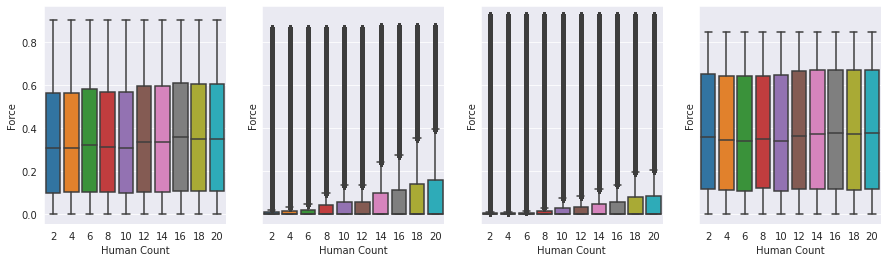

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 4), sharey=True)
sns.boxplot(x="Human Count", y="Force", data=goAloneDf, ax=ax[0])
sns.boxplot(x="Human Count", y="Force", data=referenceDf, ax=ax[1])
sns.boxplot(x="Human Count", y="Force", data=niceDf, ax=ax[2])
sns.boxplot(x="Human Count", y="Force", data=greedyDf, ax=ax[3])

<AxesSubplot:xlabel='Human Count', ylabel='Blame'>

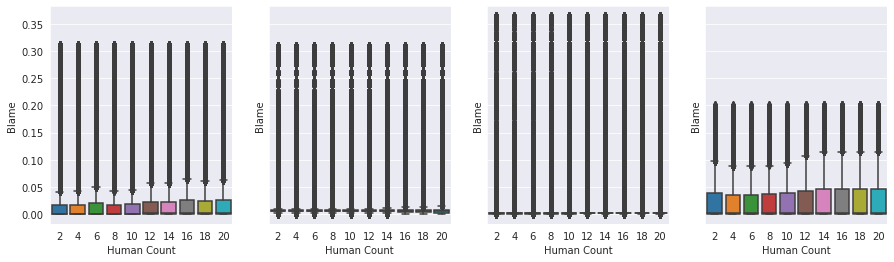

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 4), sharey=True)
sns.boxplot(x="Human Count", y="Blame", data=goAloneDf, ax=ax[0])
sns.boxplot(x="Human Count", y="Blame", data=referenceDf, ax=ax[1])
sns.boxplot(x="Human Count", y="Blame", data=niceDf, ax=ax[2])
sns.boxplot(x="Human Count", y="Blame", data=greedyDf, ax=ax[3])

<AxesSubplot:xlabel='Human Count', ylabel='Final Time'>

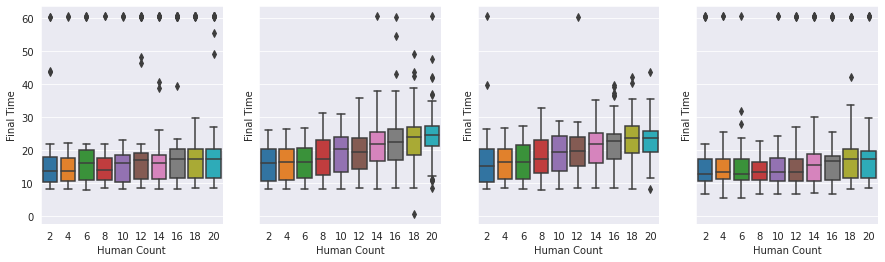

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 4), sharey=True)
sns.boxplot(x="Human Count", y="Final Time", data=gaSort, ax=ax[0])
sns.boxplot(x="Human Count", y="Final Time", data=referenceSort, ax=ax[1])
sns.boxplot(x="Human Count", y="Final Time", data=niceSort, ax=ax[2])
sns.boxplot(x="Human Count", y="Final Time", data=greedySort, ax=ax[3])

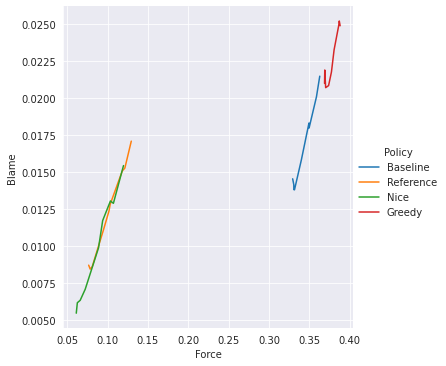

In [12]:
sns.relplot(x="Force", y="Blame", hue="Policy", kind="line", data=averageDf);

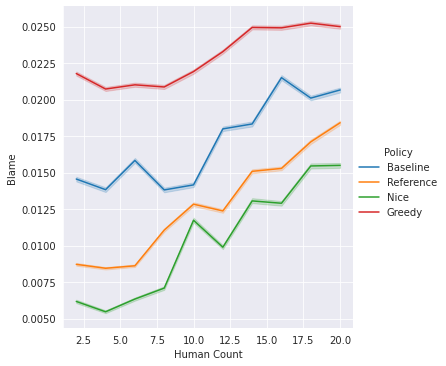

In [13]:
sns.relplot(x="Human Count", y="Blame", hue="Policy", kind="line", data=fullDf);

(2.0, 20.0)

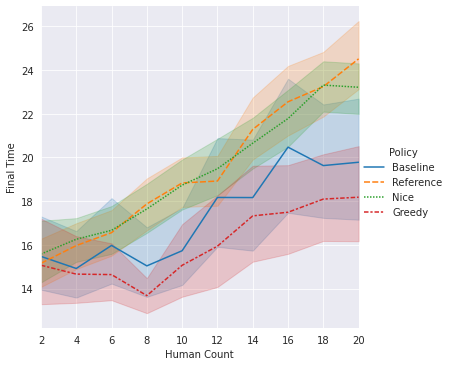

In [14]:
sns.relplot(x="Human Count", y="Final Time", hue="Policy", style="Policy", kind="line", data=fullTime);
plt.xlim(2, 20)

In [15]:
print("Total Trials: " + str(len(gaSort.index)))
gaTimeouts = gaSort[gaSort["Final Time"] > 60.0]
print("GoAlone: " + str(len(gaTimeouts.index)))
referenceTimeouts = referenceSort[referenceSort["Final Time"] > 60.0]
print("Reference: " + str(len(referenceTimeouts.index)))
niceTimeouts = niceSort[niceSort["Final Time"] > 60.0]
print("Nice: " + str(len(niceTimeouts.index)))
greedyTimeouts = greedySort[greedySort["Final Time"] > 60.0]
print("Greedy: " + str(len(greedyTimeouts.index)))

Total Trials: 1000
GoAlone: 58
Reference: 3
Nice: 2
Greedy: 32


In [16]:
# Writing some data out to a file
force = fullDf["Force"]
blame = fullDf["Blame"]
time = fullDf["Total Time"]
trial = fullDf["Trial"]
labels = fullDf["Policy"]
result = pd.concat([labels, trial, force, blame, time], axis=1, join="inner")
print(result)
result.to_csv("sim_metrics_1.csv")

        Policy  Trial     Force         Blame  Total Time
0     Baseline     17  0.000000  0.000000e+00   17.246460
1     Baseline     17  0.000000  0.000000e+00   17.246460
2     Baseline     17  0.001287  3.330669e-16   17.246460
3     Baseline     17  0.001287  3.330669e-16   17.246460
4     Baseline     17  0.001287  3.330669e-16   17.246460
...        ...    ...       ...           ...         ...
1643    Greedy     16  0.635873  3.335300e-02   11.111529
1644    Greedy     16  0.635873  3.335300e-02   11.111529
1645    Greedy     16  0.623153  2.964733e-02   11.111529
1646    Greedy     16  0.623153  2.964733e-02   11.111529
1647    Greedy     16  0.623153  2.964733e-02   11.111529

[10230024 rows x 5 columns]


<AxesSubplot:xlabel='Force', ylabel='Blame'>

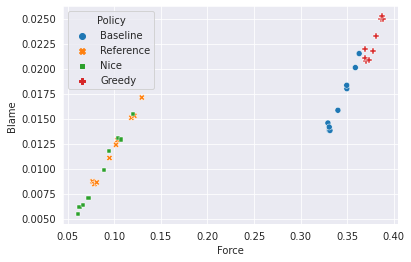

In [17]:
sns.scatterplot(data=averageDf, x="Force", y="Blame", hue="Policy", style="Policy")

<AxesSubplot:xlabel='Force', ylabel='Blame'>

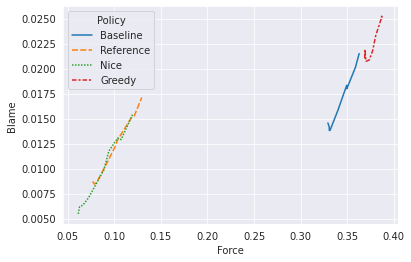

In [18]:
sns.lineplot(data=averageDf, x="Force", y="Blame", hue="Policy", style="Policy")

In [19]:
fullTime.to_csv("sim_time_1.csv")
print(fullTime)

     Human Count  Final Time    Policy
0              2   17.246460  Baseline
437            2   20.381609  Baseline
458            2   20.328616  Baseline
469            2   16.027330  Baseline
480            2   11.102436  Baseline
..           ...         ...       ...
405           20   18.828404    Greedy
579           20   11.332226    Greedy
822           20   60.538596    Greedy
600           20   19.905160    Greedy
737           20   11.147659    Greedy

[4000 rows x 3 columns]


In [20]:
# Writing some data out to a file
force = fullDf["Force"]
blame = fullDf["Blame"]
time = fullDf["Total Time"]
trial = fullDf["Trial"]
humans = fullDf["Human Count"]
labels = fullDf["Policy"]
result = pd.concat([labels, trial, humans, force, blame, time], axis=1, join="inner")
print(result)
result.to_csv("sim_metrics_1.csv")

        Policy  Trial  Human Count     Force         Blame  Total Time
0     Baseline     17            2  0.000000  0.000000e+00   17.246460
1     Baseline     17            2  0.000000  0.000000e+00   17.246460
2     Baseline     17            2  0.001287  3.330669e-16   17.246460
3     Baseline     17            2  0.001287  3.330669e-16   17.246460
4     Baseline     17            2  0.001287  3.330669e-16   17.246460
...        ...    ...          ...       ...           ...         ...
1643    Greedy     16           16  0.635873  3.335300e-02   11.111529
1644    Greedy     16           16  0.635873  3.335300e-02   11.111529
1645    Greedy     16           16  0.623153  2.964733e-02   11.111529
1646    Greedy     16           16  0.623153  2.964733e-02   11.111529
1647    Greedy     16           16  0.623153  2.964733e-02   11.111529

[10230024 rows x 6 columns]
